# Automatic Triage using Machine Learning
This project was developed in order to help triage proccess making it faster and more accurated.
The dataset used was provided by Kaggle user and can be found at:
https://www.kaggle.com/monika11/bug-triagingbug-assignment

The idea is the use of machine learning algorithms to automatically categorize issues to the proper component. As the dataset provided was too unbalanced with some components having only few samples, the workaround choosen was to develop a model considering the five most common components.

Feel free to contact me if you have any questions.

In [1187]:
import numpy as np
import pandas as pd # Pandas is an easy-to-use data structures and data analysis tools
import matplotlib.pyplot as plt # Matplot is a common Python lib for plotting
%matplotlib inline
import seaborn as sns # Seaborn is a great tool for data analysis graphs
# pd.set_option('display.max_columns', None) # To display all columns

Read the entire dataset provided using pandas

In [1188]:
df = pd.read_csv("dataset.csv")

Use of head() function to provide the first 5 lines of the dataset

In [1189]:
df.head()

,Bug ID,Product,Component,Assignee,Status,Resolution,Summary,Changed,Assignee Real Name,Classification,Flags,Hardware,Keywords,Number of Comments,Opened,OS,Priority,QA Contact,QA Contact Real Name,Reporter,Reporter Real Name,Severity,Summary.1,Tags,Target Milestone,URL,Version,Votes,Whiteboard,Alias
0,3638,JDT,UI,aeschli,VERIFIED,FIXED,Package Viewer: order resource folders before ...,2002-01-17 07:28:04,Martin Aeschlimann,Eclipse,NaN,All,NaN,3,2001-10-10 22:58:24,Windows NT,P1,NaN,NaN,aeschli,Martin Aeschlimann,major,Package Viewer: order resource folders before ...,NaN,---,NaN,2.0,0,NaN,NaN
1,3854,JDT,UI,aeschli,VERIFIED,FIXED,Wrong execution's classpath. (1GEY0W0),2002-01-18 04:02:11,Martin Aeschlimann,Eclipse,NaN,All,NaN,5,2001-10-10 23:01:58,Windows NT,P1,NaN,NaN,david_audel,David Audel,normal,Wrong execution's classpath. (1GEY0W0),NaN,---,NaN,2.0,0,NaN,NaN
2,4188,JDT,UI,aeschli,VERIFIED,FIXED,type hierachy - typo (1GJW2XJ),2002-01-28 03:12:37,Martin Aeschlimann,Eclipse,NaN,All,NaN,3,2001-10-10 23:07:31,Windows 2000,P1,NaN,NaN,erich_gamma,Erich Gamma,normal,type hierachy - typo (1GJW2XJ),NaN,---,NaN,2.0,0,NaN,NaN
3,5115,JDT,Debug,aeschli,VERIFIED,FIXED,Workspace source locator fails with mulitple p...,2001-11-13 10:11:09,Martin Aeschlimann,Eclipse,NaN,PC,NaN,10,2001-10-19 13:41:25,Windows 2000,P1,NaN,NaN,darin.eclipse,Darin Wright,normal,Workspace source locator fails with mulitple p...,NaN,---,NaN,2.0,0,NaN,NaN
4,5820,JDT,UI,aeschli,VERIFIED,FIXED,Close all editors brings up hierarchy of object,2001-11-20 16:22:35,Martin Aeschlimann,Eclipse,NaN,PC,NaN,5,2001-11-12 18:18:05,Windows 2000,P1,NaN,NaN,jed.anderson,Jed Anderson,normal,Close all editors brings up hierarchy of object,NaN,---,NaN,2.0,0,NaN,NaN


Total count for each component.
Here we can see that some components only have few samples and for this project we're going to consider only the five most common ones.

In [1190]:
df['Component'].value_counts()

UI                                          4019
Debug                                       2928
Text                                         875
Ant                                          729
Core                                         490
SWT                                          145
User Assistance                              116
Releng                                       104
Doc                                           90
Compare                                       85
Team                                          85
IDE                                           71
Search                                        68
API Tools                                     60
CVS                                           52
Update  (deprecated - use RT>Equinox>p2)      31
Resources                                     18
Build                                         10
Runtime                                       10
APT                                            9
PMC                 

Creating labels column to pandas DataFrame in order to keep components as integer values since most machine learning algorithms don't work well with strings and characters.

In [1191]:
df['labels'] = pd.Series(np.zeros(len(df)), index=df.index)
for index, row in df.iterrows():
    if(df.loc[index,'Component'] == "UI"):
        df.loc[index,'labels'] = 0
    elif(df.loc[index,'Component'] == "Debug"):
        df.loc[index,'labels'] = 1
    elif(df.loc[index,'Component'] == "Text"):
        df.loc[index,'labels'] = 2
    elif(df.loc[index,'Component'] == "Ant"):
        df.loc[index,'labels'] = 3
    elif(df.loc[index,'Component'] == "Core"):
        df.loc[index,'labels'] = 4
    else:
        df.loc[index,'labels'] = 5

Since we're going to consider only the five most common components we need to remove undesired labels. After that, we can check the new components count.

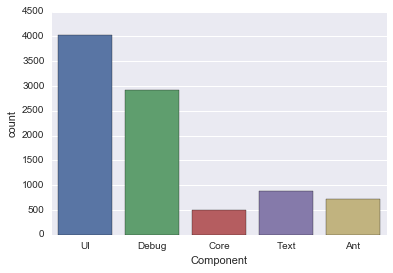

In [1192]:
df = df[df['labels'] != 5]
sns.countplot(x='Component', data=df)

The training data is still unbalanced so we need to balance using the criteria of the same number of samples for each class. 

In [1193]:
balanced_df = pd.DataFrame()
for i in df['labels'].unique():
    balanced_df = balanced_df.append(df[df['labels'] == i].iloc[:490],ignore_index=True)

Returning a random sample of dataframe created.

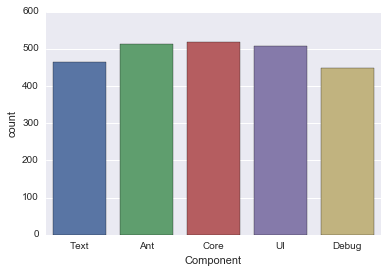

In [1194]:
df = balanced_df.sample(len(balanced_df), replace=True)
sns.countplot(x='Component', data=df)

# Approach 1: Naive Bayes step by step implementation
CountVectorizer is responsible for occurrences counting of each word per sample (Bag of Words).
Token pattern allows in this case choose only words with at least two characters while lowercase set to True transforms all the words to lowercase pattern.

Stop words is set to avoid common english words that usually don't help on text analysis while strip() function takes care of cleaning strings from unnecessary whitespaces.

In [1195]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(token_pattern=r"(?u)\b[a-zA-Z]\w+\b",stop_words='english',lowercase=True)
data = []
for i,row in df.iterrows():
    data.append(row['Summary'].strip())

Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [1196]:
from sklearn.feature_extraction.text import TfidfTransformer
X_train_counts = count_vect.fit_transform(data)
# Comment lines below if you don't want to consider idf transformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_train_counts)

Visualize a Bag of Words using a graph is difficult since each of the sentences gets represented in a high dimensional space of length equal to the vocabulary. But we can still represent this by a 2D graph using the dimension reduction, for example a PCA with two components.

K-means helps finding the cluster centers for each label bag of words in order to improve visualization.
The purpose of this algorithm is to use euclidean distance to cluster data according to the number of clusters required.

Ps: todense() function takes care of transforming bag of words on a dense matrix since we had a sparse matrix before.

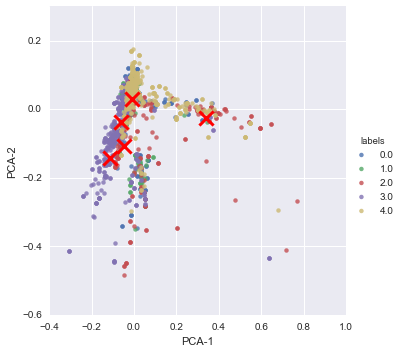

In [1197]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_tfidf.todense())
data2D = pca.transform(X_tfidf.todense())
df['PCA-1'] = pd.Series(np.zeros(len(df)), index=df.index)
df['PCA-2'] = pd.Series(np.zeros(len(df)), index=df.index)
df.loc[:,'PCA-1'] = data2D[:,0]
df.loc[:,'PCA-2'] = data2D[:,1]
sns.lmplot(x="PCA-1", y="PCA-2", hue="labels", data=df, fit_reg=False)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5).fit(X_tfidf.todense())
centers2D = pca.transform(kmeans.cluster_centers_)
plt.hold(True)
plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')

The multinomial Naive Bayes classifier is suitable for classification with multinomial model. We already have word counts for text classification and labels of each component so let's try to model using this approach. In this case, we're going to consider 80% of entire data as training data and 20% as evaluation data.

In [1198]:
from sklearn.naive_bayes import MultinomialNB
X_train_tfidf = X_tfidf[:int(X_tfidf.shape[0] * 0.8)]
labels_train = df['labels'][:int(len(df['labels']) * 0.8)]
clf = MultinomialNB().fit(X_train_tfidf, labels_train)
labels_test = df['labels'][int(len(df['labels']) * 0.8):]
X_test_tfidf = X_tfidf[int(X_tfidf.shape[0] * 0.8):]

Checking the model accuracy:

In [1199]:
predicted = clf.predict(X_test_tfidf)
print("\nAccuracy Training: " + str(np.mean(predicted == labels_test)))


Accuracy Training: 0.816326530612


# Approach 2: Naive Bayes with pipeline implementation

Using a Pipeline simplifies the proccess and instead of manually running through each of these steps, and then tediously repeating them on the test set, you get a nice, declarative interface where it's easy to see the entire model. This example extracts the bag of words, tokenizes them, counts the tokens, and then performs a tf–idf transformation before passing the resulting features along to a multinomial naive Bayes classifier.

The purpose of the parameters is to assemble several steps that can be evaluated together while setting different values (Grid Search). As result, we can obtain the best model parameters.

In [1200]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

text_clf = Pipeline([('vect', CountVectorizer(token_pattern=r"(?u)\b[a-zA-Z]\w+\b",stop_words='english',lowercase=True)),
                     ('tfidf', TfidfTransformer()),
                    #('clf', SGDClassifier( penalty='l2',alpha=1e-3, n_iter=5, random_state=42)),
                    ('clf', MultinomialNB())
                    ])
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__max_df': (0.5, 0.75, 1.0),
              'tfidf__use_idf': (True, False),
              #'clf__alpha': (1e-2, 1e-3),
              'tfidf__norm': ('l1', 'l2')
              #'clf__loss': ('perceptron', 'hinge','squared_loss','squared_hinge')
              }
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
text_clf = gs_clf.fit(df['Summary'][:int(len(df['Summary']) * 0.8)], df['labels'][:int(len(df['labels']) * 0.8)])

Checking the new model accuracy:

In [1201]:
predicted = text_clf.predict(df['Summary'][int(len(df['Summary']) * 0.2):])
print("\nAccuracy Training: " + str(np.mean(predicted == df['labels'][int(len(df['labels']) * 0.2):])))


Accuracy Training: 0.960714285714
